## Setup

In [ ]:
# Import libraries
import os
import random
import glob
import time
import pickle
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Configuration
DATA_ROOT = "/kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset"
SAVE_DIR = "/kaggle/working/jersey_project"
os.makedirs(SAVE_DIR, exist_ok=True)

SEQ_LENGTH = 8
IMG_SIZE = 96
BATCH_SIZE = 8
EPOCHS = 12
LR = 3e-4
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# set seed for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## File listing & frame reading

In [3]:
# Return list of (seq_path, label) for every sequence folder
def list_sequence_samples(root_dir):
    samples = []
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        try:
            label = int(class_name)
        except:
            continue
        for seq_name in sorted(os.listdir(class_path)):
            seq_path = os.path.join(class_path, seq_name)
            if os.path.isdir(seq_path):
                samples.append((seq_path, label))
    return samples

# Find jpgs either directly under seq_path or under first inner folder
def find_frame_paths(seq_path):
    jpgs = [f for f in os.listdir(seq_path) if f.lower().endswith(".jpg")]
    if len(jpgs) > 0:
        # exclude anchor.jpg from regular frames
        return [os.path.join(seq_path, f) for f in sorted(jpgs) if f.lower() != "anchor.jpg"]
    # check nested folder
    subfolders = [d for d in os.listdir(seq_path) if os.path.isdir(os.path.join(seq_path, d))]
    if len(subfolders) > 0:
        inner = os.path.join(seq_path, subfolders[0])
        inner_jpgs = [f for f in os.listdir(inner) if f.lower().endswith(".jpg")]
        return [os.path.join(inner, f) for f in sorted(inner_jpgs)]
    return []

## Preprocessing

In [4]:
# Load PIL image, resize, convert to array normalized for MobileNetV3Small

def load_and_preprocess_image(path, img_size=IMG_SIZE):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size), Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    # Use MobileNetV3 preprocessing: rescale to [-1, 1]
    arr = tf.keras.applications.mobilenet_v3.preprocess_input(arr)
    return arr  # H, W, 3 float32

## Sequence buildup

In [5]:
# Return numpy array of shape (T, H, W, 3) and the label as (tens, ones).
# Uses anchor.jpg if no frames exist or optionally appended for training.
    
def build_sequence_array(seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE, use_anchor_in_training=True, training_mode=True):
    # find frames
    frame_paths = find_frame_paths(seq_path)
    imgs = []
    for p in frame_paths:
        try:
            imgs.append(load_and_preprocess_image(p, img_size=img_size))
        except Exception:
            # skip corrupted frames
            continue

    # fallback to anchor if no frames
    if len(imgs) == 0:
        anchor_p = os.path.join(seq_path, "anchor.jpg")
        if os.path.exists(anchor_p):
            imgs.append(load_and_preprocess_image(anchor_p, img_size=img_size))
        else:
            # dummy black image
            imgs.append(np.zeros((img_size, img_size, 3), dtype=np.float32))

    # optionally append anchor during training
    if training_mode and use_anchor_in_training:
        anchor_p = os.path.join(seq_path, "anchor.jpg")
        if os.path.exists(anchor_p):
            try:
                imgs.append(load_and_preprocess_image(anchor_p, img_size=img_size))
            except Exception:
                pass

    # sample or pad to seq_length
    if len(imgs) >= seq_length:
        idxs = np.linspace(0, len(imgs)-1, seq_length).astype(int)
        seq = [imgs[i] for i in idxs]
    else:
        # pad by repeating last
        seq = imgs.copy()
        while len(seq) < seq_length:
            seq.append(seq[-1])
    seq = np.stack(seq, axis=0)  # (T, H, W, 3)
    return seq

## Data Split

In [6]:
all_samples = list_sequence_samples(DATA_ROOT)
random.Random(SEED).shuffle(all_samples)

n = len(all_samples)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_samples = all_samples[:n_train]
val_samples = all_samples[n_train:n_train+n_val]
test_samples = all_samples[n_train+n_val:]

print(f"Total sequences: {n}, train: {len(train_samples)}, val: {len(val_samples)}, test: {len(test_samples)}")

Total sequences: 4547, train: 3637, val: 454, test: 456


## Data load

In [ ]:
# Generator function

def generator_from_samples(samples, training_mode=True):
    for (seq_path, label) in samples:
        seq = build_sequence_array(seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE, 
                                   use_anchor_in_training=True, training_mode=training_mode)
        tens = label // 10
        ones = label % 10
        yield seq, (tens, ones)

output_signature = (
    tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    (tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32))
)

# Dataset generator
train_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(train_samples, training_mode=True),
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(val_samples, training_mode=False),
                                        output_signature=output_signature)
test_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(test_samples, training_mode=False),
                                         output_signature=output_signature)

# Batching and performance
train_ds = train_ds.shuffle(512, seed=SEED).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

## Build Model

In [8]:
def build_model(seq_length=SEQ_LENGTH, img_size=IMG_SIZE, hidden_dim=256):
    # input: (T, H, W, 3)
    inp = tf.keras.layers.Input(shape=(seq_length, img_size, img_size, 3), name="frames")
    # process each frame with MobileNetV3Small backbone (weights='imagenet')
    # use TimeDistributed to apply to each frame
    base = tf.keras.applications.MobileNetV3Small(include_top=False, 
                                                  input_shape=(img_size, img_size, 3), pooling='avg', weights='imagenet')
    base.trainable = True  # you can set to False to freeze
    td = tf.keras.layers.TimeDistributed(base)(inp)  # (B, T, feat)
    # td has shape (B, T, feat_dim)
    # apply a small Temporal CNN (1D conv over time)
    x = tf.keras.layers.Conv1D(filters=hidden_dim, kernel_size=3, padding='same', activation='relu')(td)
    x = tf.keras.layers.Conv1D(filters=hidden_dim//2, kernel_size=3, padding='same', activation='relu')(x)
    # global pooling along time to get sequence representation
    x_pool = tf.keras.layers.GlobalAveragePooling1D()(x)  # (B, hidden_dim//2)
    # two output heads
    tens_logits = tf.keras.layers.Dense(10, name='tens')(x_pool)
    ones_logits = tf.keras.layers.Dense(10, name='ones')(x_pool)
    model = tf.keras.Model(inputs=inp, outputs=[tens_logits, ones_logits])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 8, 96, 96, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 576)    │    939,120 │ frames[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 256)    │    442,624 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 128)    │     98,432 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tens (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,482,756 (5.66 MB)

 Trainable params: 1,470,644 (5.61 MB)

 Non-trainable params: 12,112 (47.31 KB)

## Compile model

In [9]:
losses = {
    "tens": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "ones": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
metrics = {
    "tens": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
    "ones": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
}
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Callback setup

In [10]:
checkpoint_path = os.path.join(SAVE_DIR, "best_tf_model.keras")
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", 
                                             save_best_only=True, save_weights_only=False)
reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Callback class

class ExactAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_ds, val_ds):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.train_exact = []
        self.val_exact = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # compute exact acc on train subset (fast: iterate a few batches or full small dataset)
        def compute_exact(ds):
            total = 0
            correct = 0
            loss_sum = 0.0
            for batch in ds:
                frames, (tens_true, ones_true) = batch
                preds = self.model.predict(frames, verbose=0)
                tens_pred = np.argmax(preds[0], axis=1)
                ones_pred = np.argmax(preds[1], axis=1)
                correct += np.sum((tens_pred == tens_true.numpy()) & (ones_pred == ones_true.numpy()))
                total += tens_true.shape[0]
            return correct / total if total>0 else 0.0

        # full val exact acc
        val_exact = compute_exact(self.val_ds.take(10))
        train_exact = compute_exact(self.train_ds.take(10))  # sample ~10% batches for speed

        self.val_exact.append(val_exact)
        self.train_exact.append(train_exact)

        # record losses if available
        if logs is not None:
            self.train_losses.append(logs.get("loss"))
            self.val_losses.append(logs.get("val_loss"))

        print(f" -> epoch {epoch+1}: val_exact={val_exact:.4f} train_exact(sample)={train_exact:.4f}")

# Instantiate callback

exact_cb = ExactAccuracyCallback(train_ds, val_ds)

## Train model

In [11]:
train_steps = len(train_samples) // BATCH_SIZE
val_steps = max(1, len(val_samples) // BATCH_SIZE)

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=train_steps,
                    validation_data=val_ds,
                    validation_steps=val_steps,
                    callbacks=[ckpt_cb, reduce_cb])

# Save training metrics
metrics_save = {
    "history": history.history,
    "train_exact": exact_cb.train_exact,
    "val_exact": exact_cb.val_exact
}
with open(os.path.join(SAVE_DIR, "training_metrics.pkl"), "wb") as f:
    pickle.dump(metrics_save, f)

print("Training finished. Best model saved to:", checkpoint_path)

# Compute exact accuracy after training once
print("Computing final exact accuracy on validation set...")
def compute_full_exact(ds):
    total = 0
    correct = 0
    for frames, (t, o) in ds:
        preds = model.predict(frames, verbose=0)
        t_pred = np.argmax(preds[0], 1)
        o_pred = np.argmax(preds[1], 1)
        correct += np.sum((t_pred == t.numpy()) & (o_pred == o.numpy()))
        total += len(t)
    return correct / total

final_val_exact = compute_full_exact(val_ds)
print("Final Val Exact Accuracy:", final_val_exact)


Epoch 1/12


I0000 00:00:1765576555.885147     103 service.cc:148] XLA service 0x789f400e9d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765576555.885842     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765576568.338458     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765576626.078455     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


454/454 ━━━━━━━━━━━━━━━━━━━━ 535s 786ms/step - loss: 1.5869 - ones_acc: 0.4374 - ones_loss: 1.2729 - tens_acc: 0.9395 - tens_loss: 0.3140 - val_loss: 0.7365 - val_ones_acc: 0.7366 - val_ones_loss: 0.6450 - val_tens_acc: 0.9799 - val_tens_loss: 0.0915 - learning_rate: 3.0000e-04
Epoch 2/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 171s 235ms/step - loss: 0.7781 - ones_acc: 0.7294 - ones_loss: 0.6496 - tens_acc: 0.9615 - tens_loss: 0.1300 - val_loss: 0.5006 - val_ones_acc: 0.8281 - val_ones_loss: 0.4647 - val_tens_acc: 0.9911 - val_tens_loss: 0.0359 - learning_rate: 3.0000e-04
Epoch 3/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 106s 233ms/step - loss: 0.5726 - ones_acc: 0.7960 - ones_loss: 0.4904 - tens_acc: 0.9806 - tens_loss: 0.0821 - val_loss: 0.4848 - val_ones_acc: 0.8527 - val_ones_loss: 0.4401 - val_tens_acc: 0.9955 - val_tens_loss: 0.0447 - learning_rate: 3.0000e-04
Epoch 4/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 106s 233ms/step - loss: 0.4655 - ones_acc: 0.8344 - ones_loss: 0.3908 - tens_acc: 0.9858 - tens_loss:

## Train/Val Loss/Accuracy curve

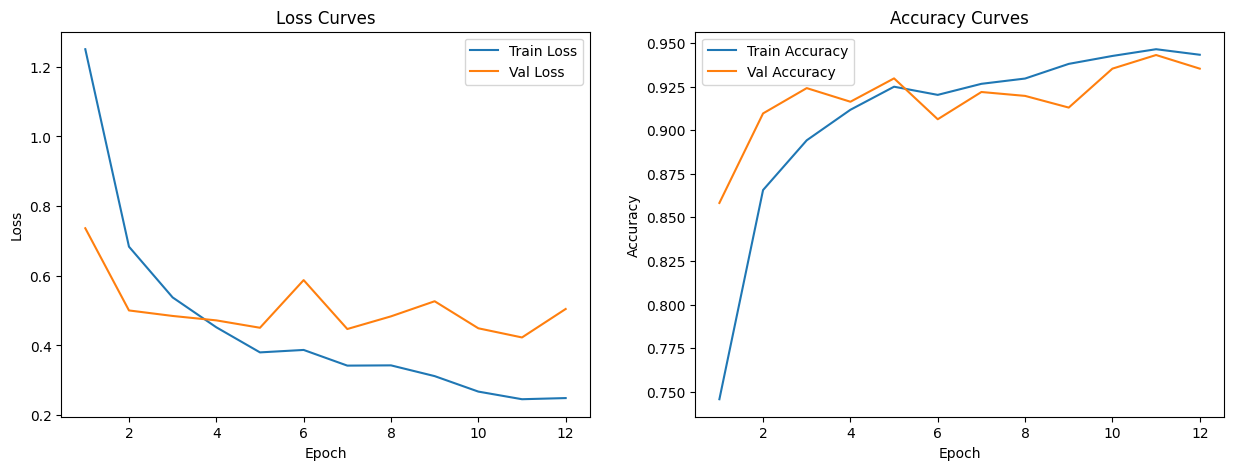

In [12]:
import matplotlib.pyplot as plt

# Extract from tensorflow history
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]

train_exact = [
    (t + o)/2    # combine tens & ones as proxy
    for t, o in zip(history.history["tens_acc"], history.history["ones_acc"])
]

val_exact = [
    (t + o)/2
    for t, o in zip(history.history["val_tens_acc"], history.history["val_ones_acc"])
]

epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(15,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs, train_exact, label="Train Accuracy")
plt.plot(epochs, val_exact, label="Val Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


## Test best model

In [13]:
best_model = tf.keras.models.load_model(checkpoint_path, compile=False)
best_model.summary()

# evaluate tens/ones accuracy via Keras evaluate (gives per-head metrics)
# create a dataset that yields inputs and a dict of outputs to feed model.evaluate
def prepare_eval_dataset(dataset):
    def map_fn(frames, label_pair):
        tens, ones = label_pair
        # model expects list of two outputs; supply dict
        return frames, {"tens": tens, "ones": ones}
    return dataset.map(map_fn).prefetch(AUTOTUNE)

eval_ds = prepare_eval_dataset(test_ds)

# manual evaluation for exact accuracy and per-digit accuracies
total = 0
correct_tens = 0
correct_ones = 0
correct_exact = 0

for batch in test_ds:
    frames, (tens_true, ones_true) = batch
    preds = best_model.predict(frames, verbose=0)
    tens_pred = np.argmax(preds[0], axis=1)
    ones_pred = np.argmax(preds[1], axis=1)

    correct_tens += np.sum(tens_pred == tens_true.numpy())
    correct_ones += np.sum(ones_pred == ones_true.numpy())
    correct_exact += np.sum((tens_pred == tens_true.numpy()) & (ones_pred == ones_true.numpy()))
    total += tens_true.shape[0]

print("TEST RESULTS")
print("Tens acc:", correct_tens / total)
print("Ones acc:", correct_ones / total)
print("Exact acc:", correct_exact / total)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 8, 96, 96, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 576)    │    939,120 │ frames[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 256)    │    442,624 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 128)    │     98,432 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tens (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,482,756 (5.66 MB)

 Trainable params: 1,470,644 (5.61 MB)

 Non-trainable params: 12,112 (47.31 KB)

TEST RESULTS
Tens acc: 0.9868421052631579
Ones acc: 0.8486842105263158
Exact acc: 0.8464912280701754


## Detailed weight summary

In [14]:
import os, csv, numpy as np

model = best_model 
out = []
for layer in model.layers:
    weights = layer.get_weights()
    if not weights:
        continue
    # flatten all weights for this layer
    all_w = np.concatenate([w.ravel() for w in weights])
    out.append({
        "layer": layer.name,
        "n_weights": all_w.size,
        "mean": float(all_w.mean()),
        "std": float(all_w.std()),
        "min": float(all_w.min()),
        "max": float(all_w.max())
    })

csv_path = "/kaggle/working/jersey_project/weights_summary.csv"
with open(csv_path, "w", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["layer","n_weights","mean","std","min","max"])
    writer.writeheader()
    writer.writerows(out)
print("Saved weights summary:", csv_path)


Saved weights summary: /kaggle/working/jersey_project/weights_summary.csv


## Inference helper

In [15]:
def infer_sequence_tf(model, seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE):
    seq = build_sequence_array(seq_path, seq_length=seq_length, img_size=img_size, training_mode=False)
    # add batch dim
    x = np.expand_dims(seq, axis=0)  # (1, T, H, W, 3)
    preds = model.predict(x, verbose=0)
    tens = int(np.argmax(preds[0], axis=1)[0])
    ones = int(np.argmax(preds[1], axis=1)[0])
    return tens*10 + ones

# quick demo on one folder
demo_path = '/kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset/66/102_19238/1'
print("Demo seq path:", demo_path)
print("Pred:", infer_sequence_tf(best_model, demo_path))

Demo seq path: /kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset/66/102_19238/1
Pred: 66


In [16]:
from tensorflow.keras.utils import plot_model
plot_path = "/kaggle/working/jersey_project/model_diagram.png"
plot_model(best_model, to_file=plot_path, show_shapes=True, expand_nested=True)
print("Saved model diagram:", plot_path)

Saved model diagram: /kaggle/working/jersey_project/model_diagram.png


# Anchor

In [17]:
import os
import numpy as np
from PIL import Image

# Frame finder
def find_frames_safe(seq_path):
    # Case 1: direct JPGs
    jpgs = [f for f in os.listdir(seq_path) if f.lower().endswith(".jpg")]
    if len(jpgs) > 0:
        return [os.path.join(seq_path, f) for f in sorted(jpgs)]

    # Case 2: search subfolder
    subs = [d for d in os.listdir(seq_path) if os.path.isdir(os.path.join(seq_path, d))]
    if len(subs) > 0:
        inner = os.path.join(seq_path, subs[0])
        jpgs_inner = [f for f in os.listdir(inner) if f.lower().endswith(".jpg")]
        return [os.path.join(inner, f) for f in sorted(jpgs_inner)]

    return []

# Preprcoess images
def preprocess_tf_image(img, img_size=96):
    img = img.resize((img_size, img_size))
    img = np.array(img).astype("float32") / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD  # same normalization as training
    return img

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])


# Anchor-only inference
def infer_anchor_only(model, seq_path, seq_length=8, img_size=96):

    anchor_path = os.path.join(seq_path, "anchor.jpg")

    # Case A: anchor.jpg exists
    if os.path.exists(anchor_path):
        img_path = anchor_path
    else:
        frames = find_frames_safe(seq_path)
        if len(frames) > 0:
            img_path = frames[0]
        else:
            # Dummy black frame
            img = Image.fromarray(np.zeros((img_size, img_size, 3), dtype=np.uint8))
            img = preprocess_tf_image(img)
            seq = np.stack([img] * seq_length)[None, ...]
            tens, ones = model.predict(seq, verbose=0)
            return int(tens.argmax()) * 10 + int(ones.argmax())

    # Load real frame
    img = Image.open(img_path).convert("RGB")
    img = preprocess_tf_image(img)
    seq = np.stack([img] * seq_length)[None, ...]

    tens, ones = model.predict(seq, verbose=0)
    t = int(tens.argmax())
    o = int(ones.argmax())
    return 10*t + o

# Evaluate anchor-only baseline
correct = 0
total = 0

print("Running anchor-only baseline...")

for seq_path, label in test_samples:
    pred = infer_anchor_only(best_model, seq_path)
    if pred == label:
        correct += 1
    total += 1

print("\nAnchor-only Exact Accuracy:", correct / total)


Running anchor-only baseline...

Anchor-only Exact Accuracy: 0.36622807017543857


## Latency check

In [18]:
# Model size
import shutil, time
saved_model_dir = "/kaggle/working/jersey_project/best_tf_model.keras"
def dir_size(path):
    total=0
    for root,dirs,files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root,f))
    return total
print("SavedModel size (MB):", dir_size(saved_model_dir)/1e6)

# Latency measurement (average per sequence)
import time

sample_paths = [p for p,_ in test_samples[:50]] # pick 50 sequences from test set
times=[]
for p in sample_paths:
    seq = build_sequence_array(p, seq_length=SEQ_LENGTH, img_size=IMG_SIZE, training_mode=False)
    x = np.expand_dims(seq, 0)
    t0=time.time()
    _ = best_model.predict(x, verbose=0)
    times.append(time.time()-t0)
print("Avg latency per sequence (ms):", np.mean(times)*1000, "std:", np.std(times)*1000)


SavedModel size (MB): 0.0
Avg latency per sequence (ms): 73.7067985534668 std: 3.3173313005738905
